# Quantum kernel estimation using a single control qubit

In this notebook, we implement a method for quantum kernel estimation (QKE) that involves measurements of only one qubit. QKE has applications in machine learning in the context of training quantum support vector machines. [1]

In [98]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit import Parameter, Gate, ControlledGate
from qiskit.extensions.unitary import UnitaryGate
from qiskit.quantum_info import Operator


# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-10-02 15:41:46,869: Credentials are already in use. The existing account in the session will be replaced.


# Turning a parametrized encoding into a gate

For our mapping (data encoding) function, we use the `ZZFeatureMap`, printed below for `feature_dimension=2`.

In [73]:
print(ZZFeatureMap(feature_dimension=2, reps=1, entanglement='linear', insert_barriers=True))

     ┌───┐ ░ ┌──────────────┐                                           
q_0: ┤ H ├─░─┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
     ├───┤ ░ ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
q_1: ┤ H ├─░─┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
     └───┘ ░ └──────────────┘└───┘└───────────────────────────────┘└───┘


For future use, we implement this feature map as a controlled unitary acting on some subset of our qubits. The following function takes as input `N`, the number of qubits in said subset; `parameters`, a list of $N$ numbers that parametrize the map; `controlled`, which we set to true when we want to realize the map as a controlled unitary; and `inverse`, which, if set to True, inverts the map before turning it into an operator.  

In [213]:
def encoding_to_gate(N, parameters, controlled=False, inverse=False):
    
    def gate_label(inverse):
        if inverse == True:
            label = '\u03A6'+str(parameters[0:N])+'.dg'
        else:
            label = '\u03A6'+str(parameters[0:N])
        return label
    
    def encoding(inverse):
        if inverse == True:
            ZZmap = ZZFeatureMap(feature_dimension=N, 
                                 reps=1, 
                                 entanglement='linear', 
                                 insert_barriers=True).bind_parameters(parameters).inverse()
        else:
            ZZmap = ZZFeatureMap(feature_dimension=N, 
                                 reps=1, 
                                 entanglement='linear', 
                                 insert_barriers=True).bind_parameters(parameters)
        return ZZmap
    
    if controlled == True:
        feature_gate = UnitaryGate(Operator(encoding(inverse)), label=gate_label(inverse)).control(1)             
    else:
        feature_gate = UnitaryGate(Operator(encoding(inverse)), label=gate_label(inverse))
        
    return feature_gate

# Generating a set of parameters

We generate a random set of $2N$ parameters to use in our circuit. In a machine learning scenario, the first half $(x_0,\dots,x_{N-1})$ of these parameters would correspond to one data point $\vec{x}_i\equiv (x_0,\dots,x_{N-1})$, and the second half $(x_N,\dots,x_{2N})$ to another point $\vec{x}_j\equiv (x_N,\dots,x_{2N})$. Note that we have one qubit for every feature in our data.

In [201]:
N = 2
parameters = np.random.uniform(size=2*N)
parameters = [round(p,2) for p in parameters]
print(parameters)

[0.32, 0.11, 0.83, 0.42]


# Quantum kernel estimation

The parameters are encoded into the circuit using the `encoding_to_gate` function defined above. Starting in the state $|0\rangle^{\otimes N}$, we apply first $\Phi(\vec{x}_i)$, then $\Phi^\dagger(\vec{x}_j)$. The probability of measuring the all-zero bitstring is then equal to the quantum kernel matrix element $K_{ij}=\lvert\langle\Phi(\vec{x}_i)|\Phi(\vec{x}_j)\rangle\rvert^2$, where $|\Phi(\vec{x}_i)\rangle=\Phi(\vec{x}_i)|0\rangle^{\otimes N}$. Note that this requires measuring all the qubits, so for single-qubit readout error probability $q\ll 1$, the probability of successfully 'detecting' the all-zero bitstring goes like $1-Nq$.

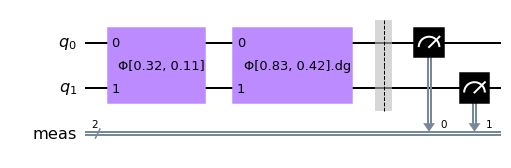

In [215]:
QKE = QuantumCircuit(N)
QKE.append(encoding_to_gate(N, parameters[0:N]), range(N))
QKE.append(encoding_to_gate(N, parameters[N:2*N], inverse=True), range(N))
QKE.measure_all()
QKE.draw()

We run our QKE circuit `num_shots` times in order to build statistics. This allows us to estimate $K_{ij}=P(\text{measure all zeros})$.

In [228]:
backend = Aer.get_backend('qasm_simulator')

num_shots = 4096
counts = execute(QKE, backend, shots=num_shots).result().get_counts()
prob_all_zeros = counts['0'*N]/num_shots

print('Kij =', prob_all_zeros)

Kij = 0.3037109375


# Quantum kernel estimation through measurements of a single qubit

By realizing our encoding as a controlled unitary, we can accomplish the same task through measurements of a single qubit (using the circuit below). Measuring the control qubit in the $X$-basis ($Y$-basis) returns the real (imaginary) part of $\langle\Phi(\vec{x}_i)|\Phi(\vec{x}_j)\rangle$.

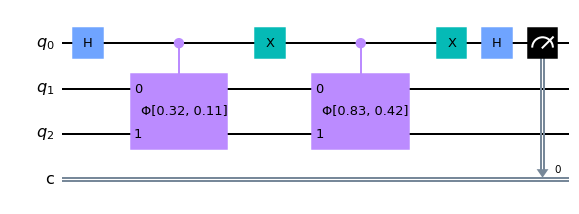

In [223]:
qc = QuantumCircuit(N+1, 1)
qc.h(0)
qc.append(encoding_to_gate(N, parameters[0:N], controlled=True), range(N+1))
qc.x(0)
qc.append(encoding_to_gate(N, parameters[N:2*N], controlled=True), range(N+1))
qc.x(0)
qc.h(0)
qc.measure(0, 0)
qc.draw()

The following function returns the circuit above, with an extra $S^\dagger$ gate before the final Hadamard in the case where `measure_Y=True`. 

In [205]:
def circuit(measure_Y=False):
    qc = QuantumCircuit(N+1, 1)
    qc.h(0)
    qc.append(encoding_to_gate(N, parameters[0:N], controlled=True), range(N+1))
    qc.x(0)
    qc.append(encoding_to_gate(N, parameters[N:2*N], controlled=True), range(N+1))
    qc.x(0)
    if measure_Y == True:
        qc.sdg(0)
    qc.h(0)
    qc.measure(0, 0)
    return qc


We run our circuit `num_shots` times, measuring in both the X- and Y-bases. We then combine the real and imaginary parts of $\langle\Phi(\vec{x}_i)|\Phi(\vec{x}_j)\rangle$ to produce an estimate for $K_{ij}=\lvert\langle\Phi(\vec{x}_i)|\Phi(\vec{x}_j)\rangle\rvert^2$.

In [229]:
[X, Y] = [circuit(), circuit(True)]
result = execute([X, Y], backend, shots=num_shots).result()

X_counts = result.get_counts(X)
Y_counts = result.get_counts(Y)

X0 = X_counts.get('0') if X_counts.get('0') != None else 0
X1 = X_counts.get('1') if X_counts.get('1') != None else 0

Y0 = Y_counts.get('0') if Y_counts.get('0') != None else 0
Y1 = Y_counts.get('1') if Y_counts.get('1') != None else 0

amplitude = ((X0+1j*Y0)-(X1+1j*Y1))/num_shots
kij = abs(amplitude)**2

print('Kij =', kij)

Kij = 0.29039859771728516


For convenience, we reprint the value obtained before (by calculating the probability of measuring the all-zero bitstring):


In [230]:
print(prob_all_zeros)

0.3037109375


[1] Havlicek et al. "Supervised learning with quantum-enhanced feature spaces", Nature 567, 209-212.